In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
a = np.load("../data/6-parameter-maps/cosmo_params_all_collage_flask_6cosmo_n625_jr0_wSN0_jz3.npz.npy", allow_pickle=True)

In [3]:
print(a.shape)
print(a[0])
print(a[1000])

(639375, 6)
[ 3.00000000e-01  7.30000000e+01  9.70000000e-01  9.00000000e-01
 -1.16650000e+00  5.77880859e-02]
[ 2.45214844e-01  6.88911133e+01  9.59697266e-01  7.90869141e-01
 -1.05946362e+00  4.63549805e-02]


In [4]:
b = np.load("../data/6-parameter-maps/maps_all_collage_flask_6cosmo_n625_jr0_wSN0_jz3.npz.npy", allow_pickle=True)

In [5]:
b.shape

(639375, 66, 66)

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import os
from datetime import datetime
import tensorflow_probability as tfp
tfd = tfp.distributions

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, PROGRESS_EPOCH=50):
        self.PROGRESS_EPOCH = PROGRESS_EPOCH
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.PROGRESS_EPOCH == 0:
            print(f"{datetime.now().strftime('%H:%M:%S')}, epoch {epoch}: ", end="")
            for key, val in logs.items():
                print(f"{key}: {val:.3f}", end= "\t")
            print()

tf.config.list_physical_devices('GPU')

2023-04-21 11:58:54.742675: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-21 11:58:55.919225: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-21 11:58:55.920385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 11:59:00.864524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-21 11:59:31.649311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[]

In [7]:
num_samples = len(a)
train_split, val_split, test_split = int(0.80*num_samples), \
            int(0.10*num_samples), int(0.10*num_samples) + 1

print(train_split, val_split, test_split, train_split+val_split+test_split)

train_x, val_x, test_x = np.split(b, [train_split, train_split+val_split])
train_y, val_y, test_y = np.split(a, [train_split, train_split+val_split])

print(train_x.shape, val_x.shape, test_x.shape)
print(train_y.shape, val_y.shape, test_y.shape)

output_num = 6

# train_y, val_y, test_y = train_y[:,1:2], val_y[:,1:2], test_y[:,1:2]
print(train_y.shape, val_y.shape, test_y.shape)

511500 63937 63938 639375
(511500, 66, 66) (63937, 66, 66) (63938, 66, 66)
(511500, 6) (63937, 6) (63938, 6)
(511500, 6) (63937, 6) (63938, 6)


In [12]:
input_shape = (66, 66, 1) 
output_num = 6
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(4, kernel_size=(2, 2), activation='relu', input_shape=input_shape),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(8, kernel_size=(2, 2), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(16, kernel_size=(2, 2), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(16, kernel_size=(2, 2), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='leaky_relu'),
  tf.keras.layers.Dense(128, activation='leaky_relu'),
  tf.keras.layers.Dense(output_num, activation='linear') # assuming 6 output parameters
])

# Compile the model
# model.compile(loss='mse', optimizer='adam')
model.compile(loss=tf.keras.losses.LogCosh(), optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 65, 65, 4)         20        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 4)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 31, 31, 8)         136       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 8)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 16)        528       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 16)        

In [ ]:
model.fit(train_x, train_y, epochs=1, batch_size=1, verbose=1)

In [ ]:
# Train the model
for i in range(2):
    print(model.evaluate(val_x, val_y))
    for train_x_batch, train_y_batch in zip(np.split(train_x, 10), np.split(train_y, 10)):
        model.fit(train_x_batch, train_y_batch, epochs=1, verbose=2)

1999/1999 [==============================] - 46s 23ms/step - loss: 12.2442
12.244248390197754
1599/1599 - 72s - loss: 0.9691 - 72s/epoch - 45ms/step
1599/1599 - 66s - loss: 0.6862 - 66s/epoch - 41ms/step
1599/1599 - 68s - loss: 0.6914 - 68s/epoch - 42ms/step
1599/1599 - 67s - loss: 0.6838 - 67s/epoch - 42ms/step


In [ ]:
predictions = model.predict(val_x)

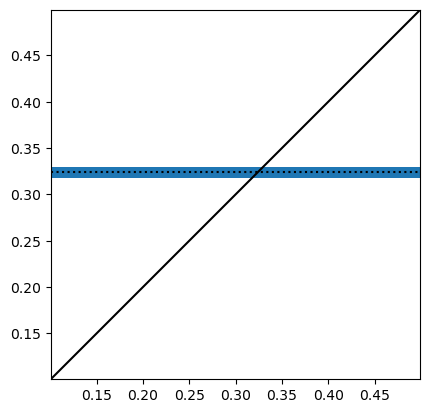

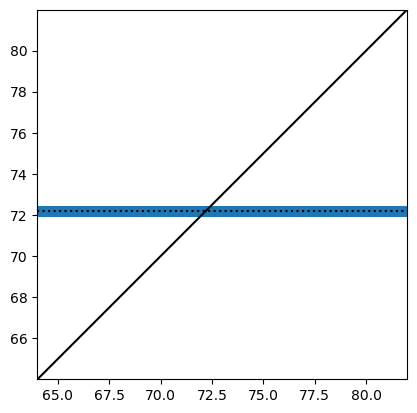

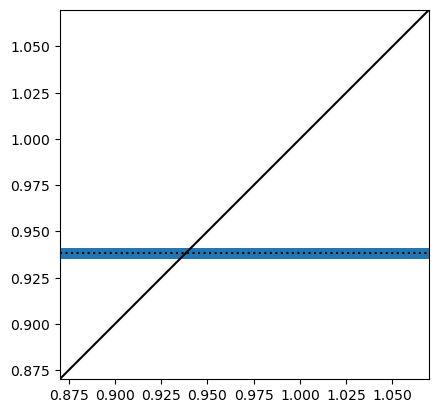

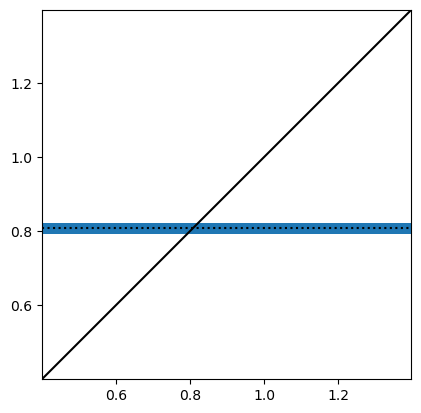

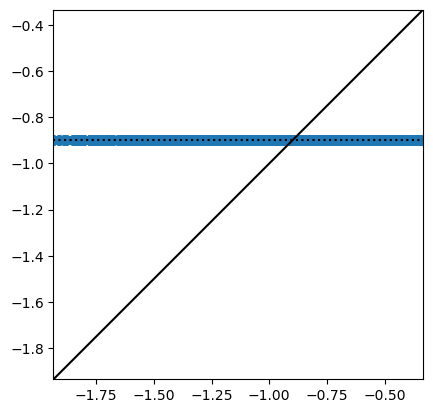

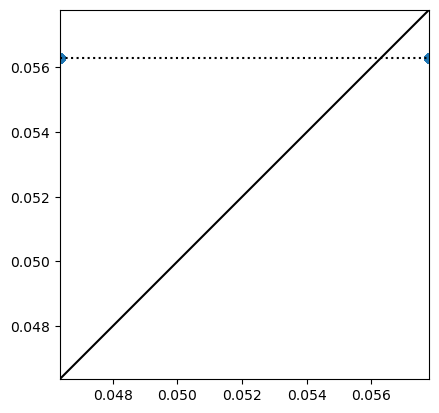

In [11]:
upp_lims = np.nanmax(val_y, axis=0)
low_lims = np.nanmin(val_y, axis=0)
for ind, (low_lim, upp_lim) in enumerate(zip(low_lims, upp_lims)):
    p = np.poly1d(np.polyfit(val_y[:, ind], predictions[:, ind], 1))
    plt.figure()
    plt.scatter(val_y[:, ind], predictions[:, ind])
    plt.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
    plt.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
    plt.xlim([low_lim, upp_lim])
    plt.ylim([low_lim, upp_lim])
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()
    plt.close()

In [ ]:
input_shape = (66, 66, 1) 

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tfp.layers.Convolution2DFlipout(filters = 4, kernel_size=(2, 2), padding='valid',
          kernel_divergence_fn=kl_divergence_function, activation=tf.nn.tanh),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    tfp.layers.Convolution2DFlipout(filters = 16, kernel_size=(2, 2), padding='valid',
          kernel_divergence_fn=kl_divergence_function, activation=tf.nn.tanh),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    tfp.layers.Convolution2DFlipout(filters = 16, kernel_size=(2, 2), padding='valid',
          kernel_divergence_fn=kl_divergence_function, activation=tf.nn.tanh),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    tf.keras.layers.Flatten(),
    tfp.layers.DenseFlipout(units = 128,
          kernel_divergence_fn=kl_divergence_function, activation=tf.nn.tanh),
    tfp.layers.DenseFlipout(units = 64,
          kernel_divergence_fn=kl_divergence_function, activation=tf.nn.tanh),
    tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(6)),
    tfp.layers.MultivariateNormalTriL(6)
])